# Multi-layer Perceptron and Backpropagation

In this lecture, we'll explore the fundamentals of deep learning by implementing the key components from scratch. By the end of this session, you should be able to:

- Understand the concept of derivatives and their numerical computation.
- Implement automatic differentiation using the `Value` class.
- Understand and perform manual backpropagation.
- Build a simple Multi-Layer Perceptron (MLP) and understand how it learns.
- Compare manual implementation with PyTorch's automatic differentiation.

Let's dive in!

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph

ModuleNotFoundError: No module named 'graphviz'

## Derivatives and Gradients
A key concept for understanding optimization in neural networks is **gradient descent** and how it works through **backpropagation**. We’ll explore how to compute derivatives and optimize the parameters of an MLP.

Remember how we calculated the numerical derivative first

\begin{align}
\frac{f(a+h)-f(a)}{h}
\end{align}

Let's manually compute the **derivative** of a simple function:
\begin{align}
f(x) = 4x^2 - 3x + 1
\end{align}

In [3]:
def f(x):
  return 4 * x ** 2 - 3 * x + 1

In [4]:
x = 2
h = 0.00001


f(x+h) ,  f(x)

(f(x+h)-f(x))/h

13.000040000044065

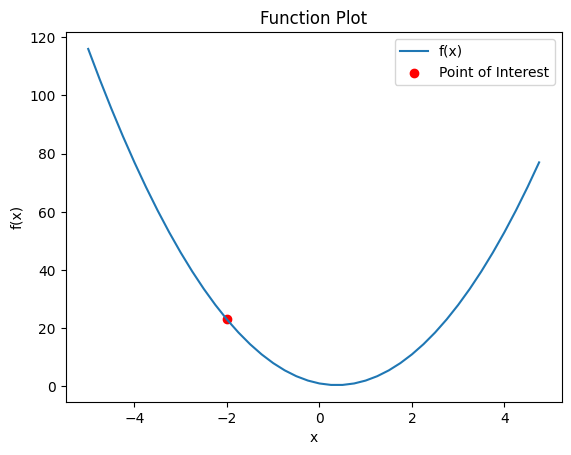

In [ ]:
xs = np.arange(-5,5,0.25)
ys = f(xs)

plt.plot(xs, ys, label='f(x)')
plt.scatter(x, f(x), color='red', label='Point of Interest')
plt.title('Function Plot')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

In [ ]:
a = 2
b = -3
c = 10

d1 = a*b + c

h = 0.0000000001
a = 2 + h

b = -3
c = 10

d2 = a*b + c

print("dd/da")
d1,d2

(d2-d1)/h

dd/da


-3.000000248221113

## Value Class

In [ ]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data}, {self.label})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out


  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other ** -1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __radd__(self, other):
    return self + other

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')
    def _backward():
      self.grad += (other * self.data**(other-1)) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    rtop = list(reversed(topo))

    self.grad = 1.
    for node in rtop:
      node._backward()

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out


In [ ]:
a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10, label= 'c')

d = a*b + c
d.label = 'd'
d

Value(data=4, d)

In [ ]:
n = a ** 2

n.backward()

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10, label= 'c')
e = a*b; e.label = 'e'

d = e + c; d.label = 'd'
f = Value(-2, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8, L)

In [ ]:
L.backward()

In [ ]:
L.grad = 1
L._backward()
d._backward()
e._backward()

In [ ]:
L.grad = 1
d.grad = -2
f.grad = 4
c.grad = -2
e.grad = -2
a.grad = 6
b.grad = -4

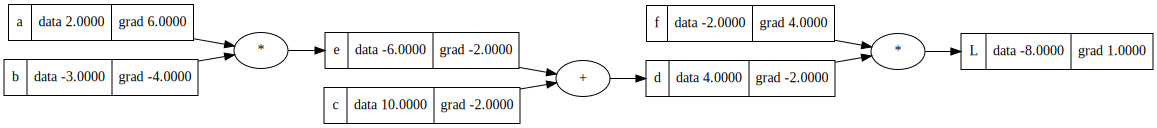

In [ ]:
draw_dot(L)

## Manual Backpropagation




In [ ]:
dL/db = -4

e = a*b
a

dL/db =  = dL/de(-2) * de/db  (2)

de/db = ?

In [ ]:
def numerical_derivative():
  h = 0.00001
  a = 2
  b = -3
  c = 10
  e = a*b

  d = e+c
  f = -2
  L1 = d*f

  a = 2
  b = -3 + h
  c = 10
  e = a*b

  d = e+c
  f = -2
  L2 = d*f

  return (L2-L1)/h
numerical_derivative()

-4.000000000026205

## Manual Optimization

In [ ]:
a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10, label= 'c')
e = a*b; e.label = 'e'

d = e + c; d.label = 'd'
f = Value(-2, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8, L)

In [ ]:
L.backward()

In [ ]:
a += Value(0.001) * a.grad
b += Value(0.001) * b.grad
c += Value(0.001) * c.grad
f += Value(0.001) * f.grad

e = a * b
d = e + c
L = d * f
L

Value(data=-7.928064095999999, )

## Automatic Differentiation

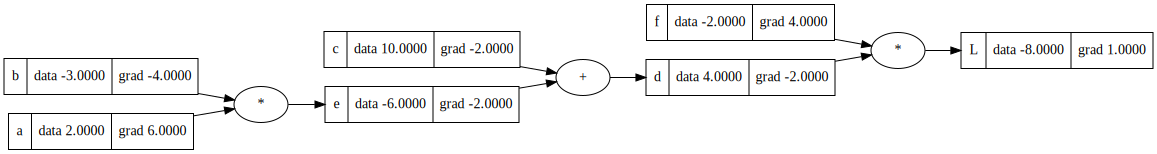

### Topological Sorting



![](https://drive.google.com/uc?export=view&id=1bx9WRtJhNzm1S2EZ3pEYBhMmxI5zEDvI)

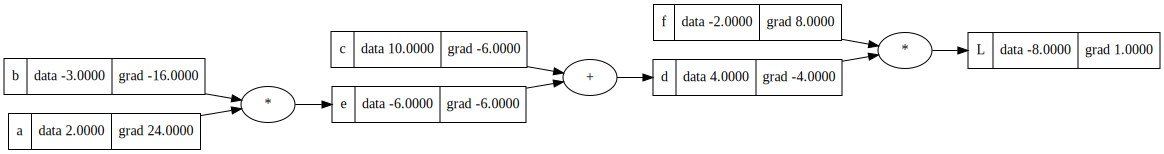

### MLP

Each neuron computes a weighted sum of its inputs, adds a bias, and applies an activation function (in this case, `tanh`).

Mathematically, for inputs \( x \) and weights \( w \), the neuron's output is:

\begin{align}
\text{output} = \tanh\left(\sum_{i} w_i x_i + b\right)
\end{align}

### Perceptron/ Artificial Neuron

An MLP consists of multiple layers of neurons. Each layer transforms its inputs and passes them to the next layer.

![](https://drive.google.com/uc?export=view&id=1OSWBdl0zubXX5ABRspK4uqvlutZCJdWo)


In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

output = n.tanh() ; output.label ='out'

output.backward()

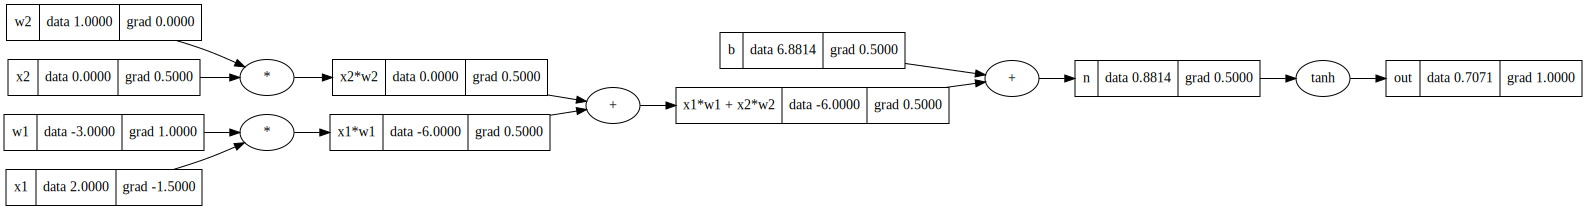

In [ ]:
draw_dot(output)

### Multiple Layers

In [ ]:
import random

In [ ]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
z
class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



MLP and input initialization

In [ ]:
n = MLP(2,[4,4,1])
o = n([1,2])
print()
o.backward()

Forward pass

In [ ]:
n.parameters()

[Value(data=0.7391633855443498, ),
 Value(data=-0.4633138654256823, ),
 Value(data=0.27338680246334945, ),
 Value(data=0.2514510156744807, ),
 Value(data=0.06722177741416813, ),
 Value(data=-0.3330666869197003, ),
 Value(data=-0.8443200396991257, ),
 Value(data=-0.7886266551685179, ),
 Value(data=-0.07791613164028255, ),
 Value(data=0.8945930983753534, ),
 Value(data=0.040974768094919956, ),
 Value(data=0.3240290397930279, ),
 Value(data=-0.12817506856985283, ),
 Value(data=0.2013988908260005, ),
 Value(data=0.6985114856604295, ),
 Value(data=-0.049968220631305016, ),
 Value(data=-0.49586190137944874, ),
 Value(data=-0.21588502888423444, ),
 Value(data=-0.19547255678849185, ),
 Value(data=-0.6245368322915008, ),
 Value(data=0.6238073413698395, ),
 Value(data=0.5073410851863083, ),
 Value(data=-0.944820278951918, ),
 Value(data=-0.9266982541897131, ),
 Value(data=-0.23092724747632687, ),
 Value(data=0.2439262050699249, ),
 Value(data=-0.6660924307013258, ),
 Value(data=-0.83355735005191

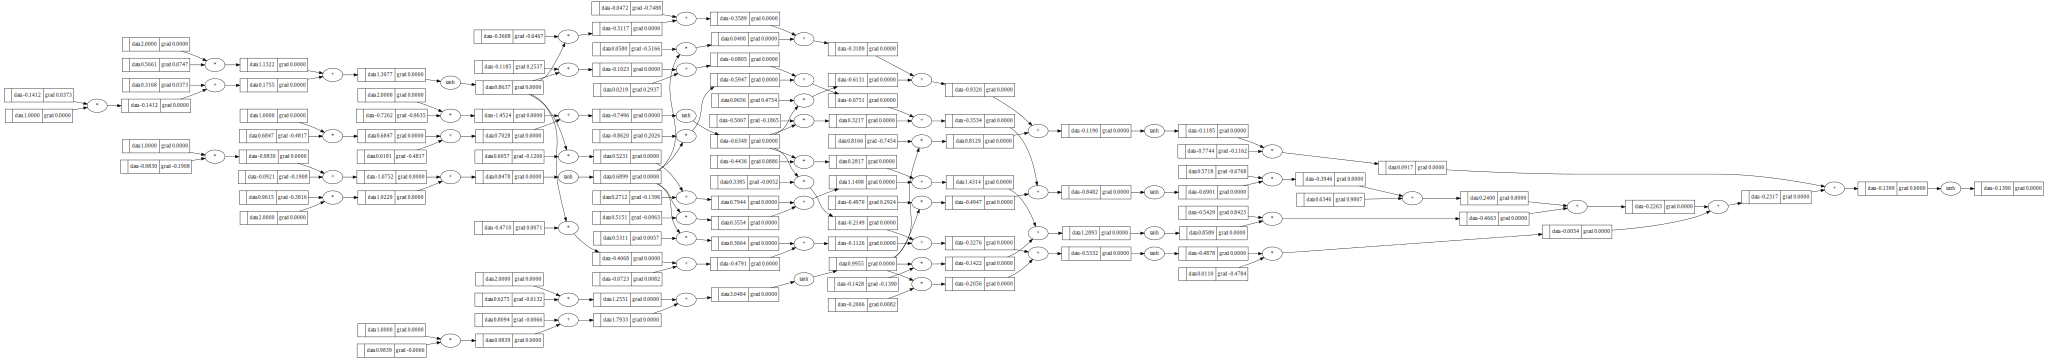

In [ ]:
draw_dot(n([1,2]))

Backward pass

Update

Value(data=0.5097805886645809)


[Value(data=0.17582563875767873),
 Value(data=0.1672062827028931),
 Value(data=0.17364478234266797)]

Calculating loss

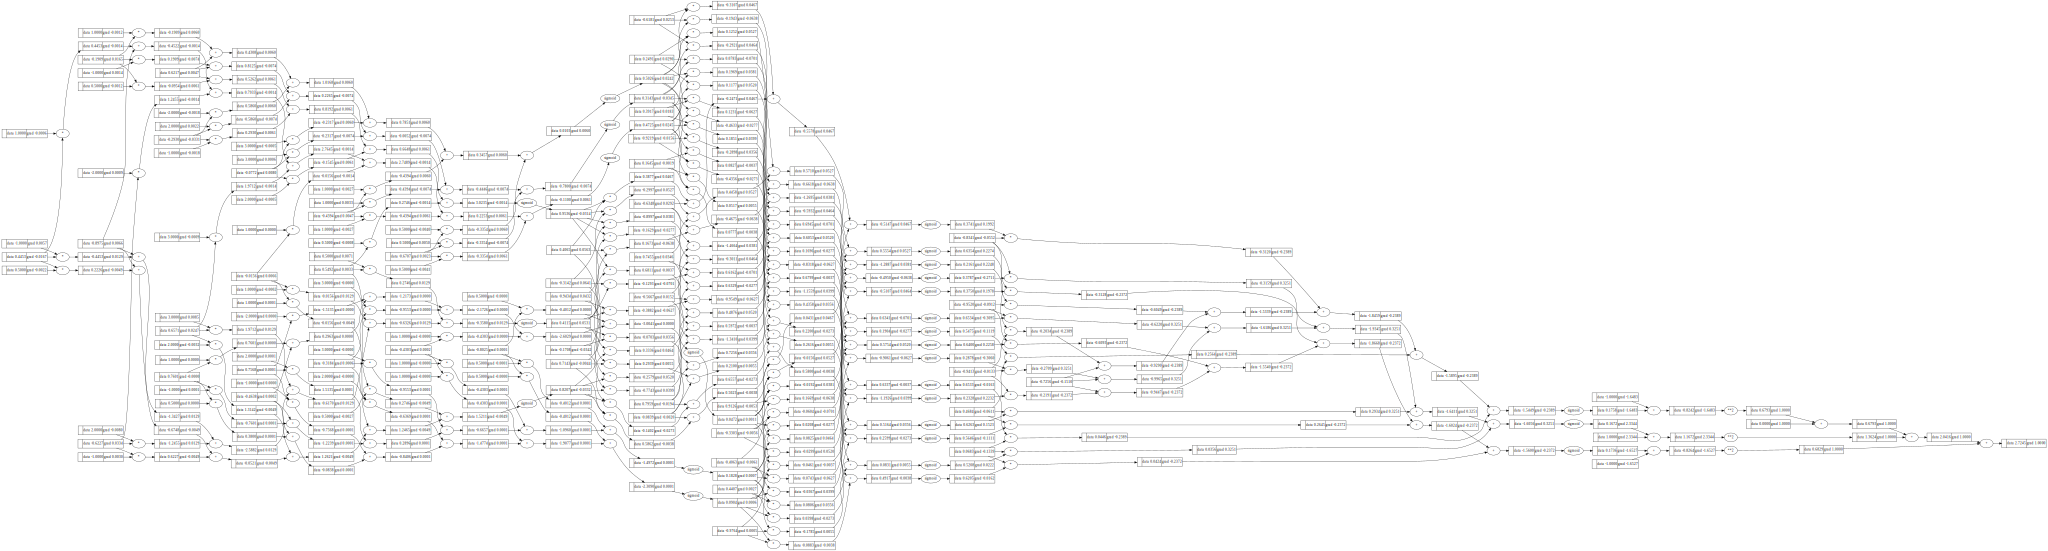

## Gradient Descent Optimization

We’ll use **gradient descent** to optimize our parameters. We will implement manual parameter updates and see how the loss decreases over time.


Value(data=4.8136497053754495)
Value(data=0.6586365629932838)
Value(data=0.17717230664074474)
Value(data=0.10959776876583502)
Value(data=0.082706828170451)
Value(data=0.06626148795991521)
Value(data=0.05511762280810571)
Value(data=0.047085310160568355)
Value(data=0.04103400260703679)
Value(data=0.03631897928598456)
Value(data=0.03254625045899883)
Value(data=0.02946192032765809)
Value(data=0.02689525431983757)
Value(data=0.02472734470988497)
Value(data=0.022872909018706394)
Value(data=0.021269233405206516)
Value(data=0.019869197303409105)
Value(data=0.0186367275503635)
Value(data=0.017543751084887454)
Value(data=0.016568101075207804)


[Value(data=0.9426453261821216),
 Value(data=-0.9127633755282841),
 Value(data=0.9247117949660546)]

[Value(data=0.9694392224977436),
 Value(data=0.12972661856210055),
 Value(data=0.20712469749791362)]

Value(data=1.2754841148094453)

## PyTorch Version

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001192092896
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
type(x1.dtype)

torch.dtype

In [ ]:
x1.data

tensor([2.], dtype=torch.float64)

In [ ]:
x1.grad

tensor([-1.5000], dtype=torch.float64)

# Homework

If you want to catch up on the fundamentals of derivatives you can watch the following videos from 3 Blue 1 Brown.

* [The paradox of the derivative](https://www.youtube.com/watch?v=9vKqVkMQHKk)
* [Derivative formulas through geometry](https://www.youtube.com/watch?v=S0_qX4VJhMQ)
* [Visualizing the chain rule and product rule](https://www.youtube.com/watch?v=YG15m2VwSjA)

You can follow an interactive blog article for a [perceptron](https://jalammar.github.io/feedforward-neural-networks-visual-interactive/) or a[neural network training](https://jalammar.github.io/visual-interactive-guide-basics-neural-networks/) from Jay Alammar.

## Manual optimization

Optimize the follwing function $ f(x) = 6x^2 -4x + 8$ manually and write the optimum value for x.

## Multi-variate Derivateive

a fonksiyon a is defined as $ a=3x+5 $ şeklinde and a function d is defined as
$d(a,b,c) = 3a^2b + c$. For the values $x=0.5, b=4, c=-7$  calculate the derivatives of x,a,b,c using the numerical derivative operation.